In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import matplotlib.patches as mpatches
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

2022-12-13 09:18:50.305496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 09:18:50.422322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-13 09:18:50.422345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 09:18:50.448846: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 09:18:51.3532

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
# load cluster assignments
cdf = pd.read_csv("clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


In [20]:
check = 'Dna'

keys = ['ND', 'HFD8', 'HFD14']

for k in keys:
    data = adata[k]
    print(f"==== {k} ====")
    print([x for x in data.var_names if check.upper() in x])

==== ND ====
['DNAJB2', 'DNAJC1', 'DNAJC10', 'DNAJC24', 'DNAJC17', 'DNAJC5', 'DNASE1L1', 'DNAJC19', 'DNAJB14', 'DNAJB4', 'DNAJA1', 'DNAJB5', 'DNAJC25', 'DNAJC8', 'DNAJC16', 'DNAJC11', 'DNAJC2', 'DNAJB6', 'DNAJC30', 'DNAAF5', 'DNAAF3', 'DNAJB13', 'DNAJB12', 'DNA2', 'DNAJC12', 'DNAJC14', 'DNAJB1', 'DNASE2A', 'DNAJA2', 'DNASE1L3', 'DNAJC9', 'DNAJC15', 'DNAJC3', 'DNAJA4', 'DNAJC13', 'DNAH2', 'DNAJC7', 'DNAJC27', 'DNAJB9', 'DNAAF2', 'DNAJC21', 'DNAL4', 'DNAJA3', 'DNAJB11', 'DNAJC28', 'DNASE1L2', 'DNAH8', 'DNAJC18', 'DNAJC4']
==== HFD8 ====
['DNAJB2', 'DNAJB3', 'DNAJC1', 'DNAJC10', 'DNAJC24', 'DNAJC17', 'DNAJC5', 'DNASE1L1', 'DNAJC19', 'DNAJB14', 'DNAJB4', 'DNAJA1', 'DNAJB5', 'DNAJC25', 'DNAJC6', 'DNAJC8', 'DNAJC16', 'DNAJC11', 'DNAJC2', 'DNAJB6', 'DNAJC30', 'DNAAF5', 'DNAAF3', 'DNAJB13', 'DNAJB12', 'DNA2', 'DNAJC12', 'DNAJC14', 'DNAJB1', 'DNASE2A', 'DNAJA2', 'DNASE1L3', 'DNAJC9', 'DNAH12', 'DNAJC15', 'DNAJC3', 'DNAJA4', 'DNAJC13', 'DNAH2', 'DNAJC7', 'DNAJC27', 'DNAJB9', 'DNAAF2', 'DNAL1', '

In [5]:
# break

ND nn9_pca50_r0.95
done


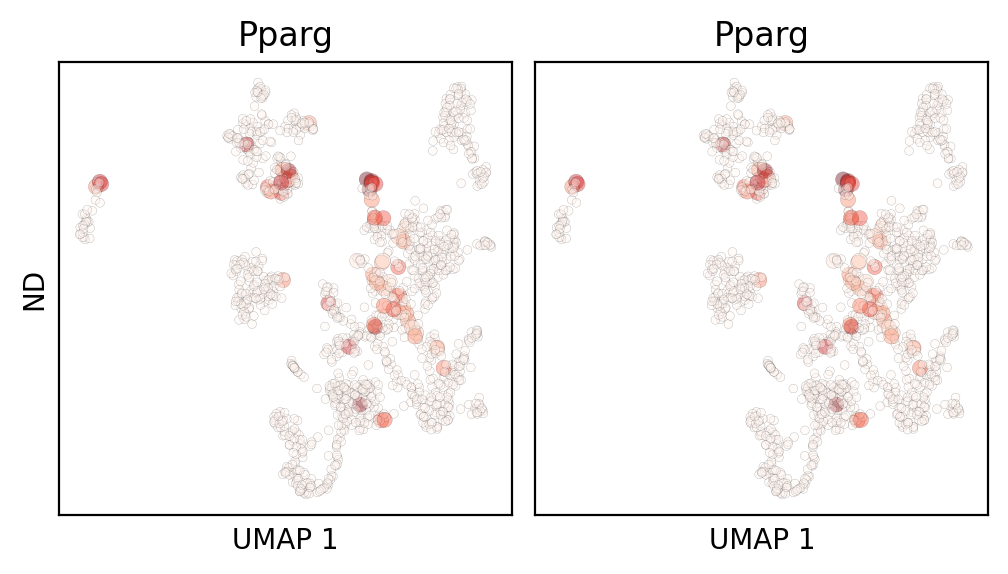

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = "w"
pltSize = 3
# keys = ['ND', 'HFD8', 'HFD14']
keys = ['ND']
# query = ['C1QA', 'APOE', 'C1QB', 'PF4', 'CCL8']
query = ['PPARG', 'Pparg']
query = [x.upper() for x in query]
# ctype = 'Monocytes'


res = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    print(key, runKey)
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
        
    # set up th plot
    nPlots = len(query)

    plt.rcParams['figure.figsize'] = nPlots*pltSize, pltSize
        
    fig, axs = plt.subplots(1, nPlots, sharey=True, subplot_kw=dict(box_aspect=1))
    axs = axs.ravel()


    # plot the expression of each validation gene
    for i, g in enumerate(query):

        mask = df[g] > 0
        c = np.where(mask, "tomato", "w")
        s = np.where(mask, 30, 10)
        y_pred = np.where(mask, 1, 0)

        axs[i].scatter(embedding[: , 0] , 
                             embedding[:, 1] , 
                             c=df[g],
                             cmap='Reds',
                             edgecolor="k",
                             lw=0.1,
                             s=s,
                             alpha=0.4)
        
        axs[i].set_title(str(g).lower().capitalize())
        axs[i].set_xlabel("UMAP 1")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
        
        if i == 0:
            axs[i].set_ylabel(key)

    
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)


res = pd.DataFrame(res)
print('done')

In [7]:
# break

{'Key': 'HFD8', 'cellType': 'Macrophages', 'Gene': 'PLIN2', 'accuracy': 0.5933365997060265, 'precision': 0.4624003984063745}
{'Key': 'HFD8', 'cellType': 'Macrophages', 'Gene': 'TREM2', 'accuracy': 0.7878490935815776, 'precision': 0.7613168724279835}
{'Key': 'HFD8', 'cellType': 'Macrophages', 'Gene': 'CD9', 'accuracy': 0.5979095214764004, 'precision': 0.4514872521246459}
{'Key': 'HFD8', 'cellType': 'Macrophages', 'Gene': 'CD63', 'accuracy': 0.7989547607382003, 'precision': 0.7323943661971831}
{'Key': 'HFD14', 'cellType': 'Macrophages', 'Gene': 'PLIN2', 'accuracy': 0.7226538222498446, 'precision': 0.6887250494515375}
{'Key': 'HFD14', 'cellType': 'Macrophages', 'Gene': 'TREM2', 'accuracy': 0.8713486637663145, 'precision': 0.8583489681050657}
{'Key': 'HFD14', 'cellType': 'Macrophages', 'Gene': 'CD9', 'accuracy': 0.7271597265382225, 'precision': 0.7775169535732916}
{'Key': 'HFD14', 'cellType': 'Macrophages', 'Gene': 'CD63', 'accuracy': 0.8612492231199502, 'precision': 0.8227930066911289}
do

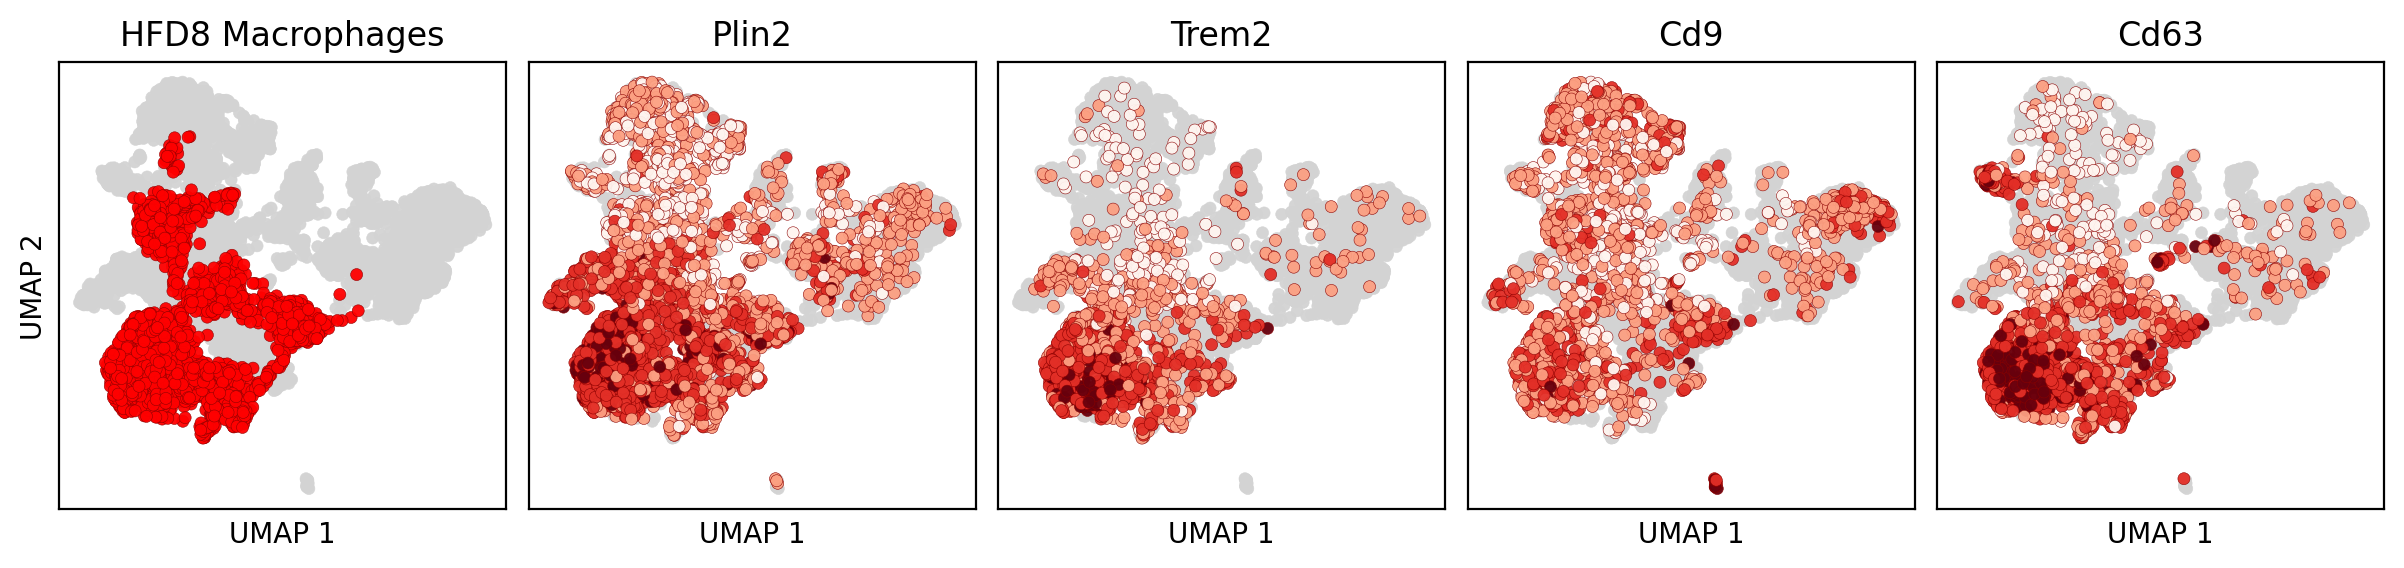

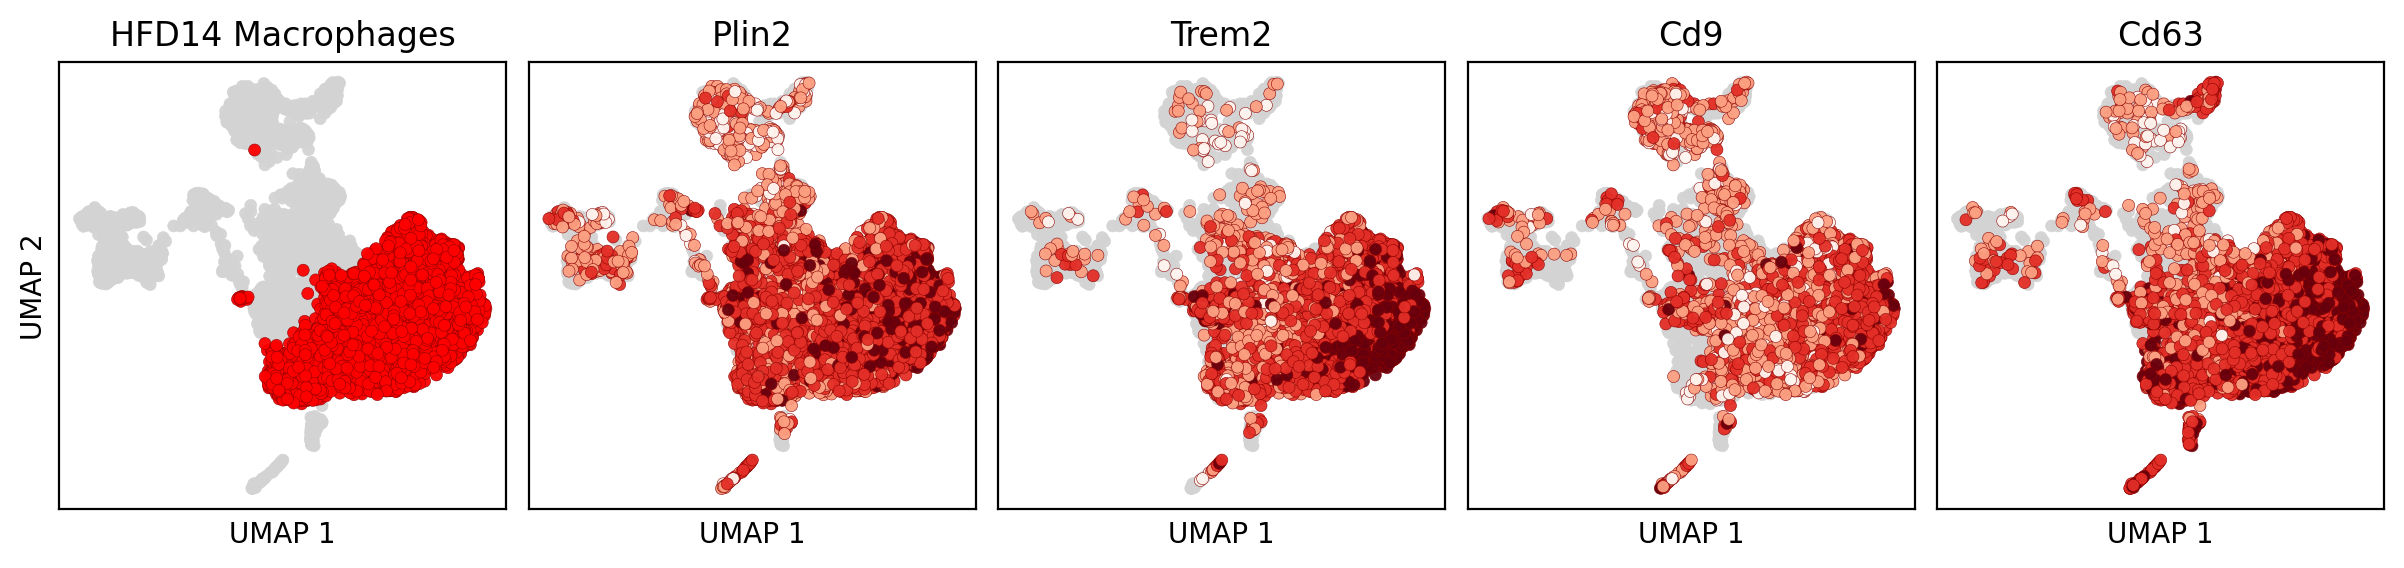

In [16]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = "w"
pltSize = 3
size = 75
lw = 0.2
alpha = 0.95
t = 0 # gene expression threshold
shadeCells = True
ncolor = 4
colorClusters = False
ctype = 'Macrophages'

keys = ['ND', 'HFD8', 'HFD14']
keys = ['HFD8', 'HFD14']
query = ['Plin2', 'Trem2', 'Cd9', 'Cd63']

query = [x.upper() for x in query]


res = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
        
    # set up th plot
    nPlots = len(query) + 1

    plt.rcParams['figure.figsize'] = nPlots*pltSize, pltSize
        
    fig, axs = plt.subplots(1, nPlots, sharey=True, subplot_kw=dict(box_aspect=1))
    axs = axs.ravel()

    cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
    
    mask = clusterIds.isin(cellTypeIds)
    order = np.argsort(mask)
    handles = []
    if colorClusters:    
        colorlist = ut.ncolor(len(cellTypeIds), cmap='Spectral')
        c = ['lightgrey'] * len(mask)
        ec = ['lightgrey'] * len(clusterIds)
        for i, cidx in enumerate(cellTypeIds):
            c = np.where(clusterIds == cidx, colorlist[i], c)
            ec = np.where(clusterIds == cidx, 'k', ec)
            
            handle = mpatches.Patch(color=colorlist[i], 
                                    ec='k', 
                                    label=f"{cidx}")
            handles.append(handle)

    else:
        c = np.where(mask, 'r', 'lightgrey')
        ec = np.where(mask, "darkred", "lightgrey")
        
    c = np.array(c)
    ec = np.array(ec)
    y_true = np.where(mask, 1, 0)

    axs[0].scatter(embedding[: , 0][order], 
                   embedding[:, 1][order], 
                   facecolor=c[order],
                   edgecolor=ec[order],
                   marker=".",
                   lw=lw,
                   s=size,
                   alpha=alpha)

    axs[0].set_title(f"{key} {ctype}")
    axs[0].set_xlabel("UMAP 1")
    axs[0].set_ylabel("UMAP 2")
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    
    if colorClusters:  
        axs[0].legend(handles=handles, title='Cluster', loc='lower left')


    # plot the expression of each validation gene
    for i, g in enumerate(query):
        plotNum = i + 1

        mask = df[g] > t
        order = np.argsort(mask)
        c = np.where(mask, "r", "lightgrey")
        if shadeCells:
            bins = np.linspace(0, df[g].max(), ncolor+1)
            colornames = ut.ncolor(ncolor, 'Reds')
            c = pd.cut(df[g], bins=bins, labels=colornames).astype(str)
            c = c.fillna("lightgrey").to_numpy()
            c = np.where(c == 'nan', "lightgrey", c)
            # print(c)
            # c = df['binned'] = pd.cut(df['percentage'], bins=bins, labels=labels)
        ec = np.where(mask, "darkred", "lightgrey")
        y_pred = np.where(mask, 1, 0)

        axs[plotNum].scatter(embedding[: , 0][order] , 
                             embedding[:, 1][order] , 
                             facecolor=c[order],
                             edgecolor=ec[order],
                             marker=".",
                             lw=lw,
                             s=size,
                             alpha=alpha)
        
        axs[plotNum].set_title(str(g).lower().capitalize())
        axs[plotNum].set_xlabel("UMAP 1")
        axs[plotNum].set_yticks([])
        axs[plotNum].set_xticks([])

        """Compute jaccard sim with the label """

        row = {
            'Key' : key,
            'cellType' : ctype,
            'Gene' : g,
            # 'jaccrd' : metrics.jaccard_score(y_true, y_pred),
            'accuracy' : metrics.accuracy_score(y_true, y_pred),
            'precision' : metrics.precision_score(y_true, y_pred),
        }
        print(row)
        res.append(row)

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)

res = pd.DataFrame(res)
print('done')

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = "w"
pltSize = 3
keys = ['ND']
clusterId = 3
query = ['COX6B2']
query = [x.upper() for x in query]
ctype = 'Macrophages'



res = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    print(key, runKey)
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
        
    # set up th plot
    nPlots = len(query) + 1

    plt.rcParams['figure.figsize'] = nPlots*pltSize, pltSize
        
    fig, axs = plt.subplots(1, nPlots, sharey=True, subplot_kw=dict(box_aspect=1))
    axs = axs.ravel()

    cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
        
    mask = (clusterIds == clusterId)
    c = np.where(mask, 'r', 'w')
    s = np.where(mask, 30, 10)
    y_true = np.where(mask, 1, 0)

    axs[0].scatter(embedding[: , 0], 
                   embedding[:, 1], 
                   c=c,
                   edgecolor="k",
                   s=s,
                   lw=0.1,
                   alpha=0.8)

    axs[0].set_title(f"{key} {ctype}")
    axs[0].set_xlabel("UMAP 1")
    axs[0].set_ylabel("UMAP 2")
    axs[0].set_yticks([])
    axs[0].set_xticks([])


    # plot the expression of each validation gene
    for i, g in enumerate(query):
        plotNum = i + 1

        mask = df[g] > 0
        c = np.where(mask, "tomato", "w")
        s = np.where(mask, 30, 10)
        y_pred = np.where(mask, 1, 0)

        axs[plotNum].scatter(embedding[: , 0] , 
                             embedding[:, 1] , 
                             c=df[g],
                             cmap='Reds',
                             edgecolor="k",
                             s=s,
                             lw=0.1,
                             alpha=0.4)

        axs[plotNum].set_title(g)
        axs[plotNum].set_xlabel("UMAP 1")
        axs[plotNum].set_yticks([])
        axs[plotNum].set_xticks([])

        """Compute jaccard sim with the label """

        row = {
            'Key' : key,
            'cellType' : ctype,
            'Gene' : g,
            'jaccrd' : metrics.jaccard_score(y_true, y_pred),
            'accuracy' : metrics.accuracy_score(y_true, y_pred),
            'precision' : metrics.precision_score(y_true, y_pred),
        }
        
        print(row)

        res.append(row)

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.15)


res = pd.DataFrame(res)
print('done')

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['figure.facecolor'] = "w"
pltSize = 3
keys = ['ND', 'HFD8', 'HFD14']
ctype = 'Macrophages'


query = {
    "ND" : [1],
    "HFD8" : [4],
    "HFD14" : [15],
}

res = []

fig, axs = plt.subplots(1, 3, sharey=True, subplot_kw=dict(box_aspect=1))
axs = axs.ravel()

for i, key in enumerate(keys):
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    print(key, runKey)
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    # get the clusters of interest
    cellTypes = cid[key]
    cellTypeIds = query[key]
    mask = clusterIds.isin(cellTypeIds)        
    
    
    c = np.where(mask, 'r', 'w')
    s = np.where(mask, 30, 10)
    a = np.where(mask, 0.7, 0.1)
    y_true = np.where(mask, 1, 0)

    axs[i].scatter(embedding[: , 0], 
                   embedding[:, 1], 
                   c=c,
                   edgecolor="k",
                   s=s,
                   alpha=a)

    axs[i].set_title(f"{key} {ctype}")
    axs[i].set_xlabel("UMAP 1")
    axs[i].set_ylabel("UMAP 1")
    axs[i].set_yticks([])
    axs[i].set_xticks([])